In [4]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
import Config

In [2]:
res = 4096
numBins = 10
degree = 0

In [3]:
# This is the actual file containing all of the data
starFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are detected, true_ra and true_dec which get used to convert into healPixels.
starData = fitsio.read(starFile, columns = ['detected', 'true_ra', 'true_dec',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'match_flag_1.5_asec'])

In [4]:
# These are in degrees which is why lonlat is set to True in the next cell.
RA = starData['true_ra']
DEC = starData['true_dec']
# This is used for detection rates, each point is either a 0 (no detection) or a 1 (detection)
DETECTED = starData['detected']
# Everything from here on out is simply used in order to filter the data
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
ARCSECONDS = starData['match_flag_1.5_asec']

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2))[0]

# This reduced the data down to the actually valid pixels.
DETECTED = DETECTED[cutIndices]
RA = RA[cutIndices]
DEC = DEC[cutIndices]

In [5]:
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPixels = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)

In [6]:
# This sorts by the pixel in order to make following methods more efficient.
sortInds = starPixels.argsort()
starPix = starPixels[sortInds[::1]]
DET = DETECTED[sortInds[::1]]

In [7]:
# These are indices that will be looping through the pixStar and starPix arrays in parallel.
uniqInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
pixStar = np.unique(starPix) # The unique pixels, with no repeats.
detStar = np.zeros_like(pixStar)
injStar = np.zeros_like(pixStar)

while starInd < len(starPix):
    if pixStar[uniqInd] == starPix[starInd]: # If the pixels match up in the arrays.
        detStar[uniqInd] += DET[starInd]     # Add one if there was a detection at this location.
        injStar[uniqInd] += 1                # Add one to the corresponding spot in the balStar array.
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.
        
# This loads in all of the file names of the survey conditions
condFiles = Config.files
condMapsExt = []

# This loops over every condition file except for stellar density which has a different format
for i in range(len(condFiles) - 1):
    condData = fitsio.read(condFiles[i]) # This reads in the data
    condSigExt = np.full(12*(4096**2), -1.6375e+30) # Gives a default value
    condSigExt[condData['PIXEL']] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals
    condSigExt[condSigExt<-1000]=-1000000000 # Masks all non valid pixels
    if res != 4096:
        condSigExt=hp.ud_grade(condSigExt, res) # Only degrades if necessary (this is very time consuming)
    condMapsExt.append(condSigExt[pixStar]) # Only stores the values that are in pixels with injections
    
stelDensExt = fitsio.read(condFiles[-1])['I'].flatten() # Loads in the stellar density
stelDensExt[stelDensExt < 0] = -1000000000 # Masks all non valid pixels
if res != 4096:
    stelDensExt=hp.ud_grade(stelDensExt, res) # Degrades if necessary
condMapsExt.append(stelDensExt[pixStar])

condMapsExt = np.array(condMapsExt, dtype = object) # Converts to an array

validIndices = np.full(len(pixStar), True, dtype = bool)
# The only valid indices are ones where every survey property is unmasked
for cond in condMapsExt:
    tempValidIndices = np.full(len(pixStar), True, dtype = bool)
    tempValidIndices[np.where(cond < -1000000)[0]] = False
    validIndices = validIndices & tempValidIndices
    
condMaps = []
# Degrades all of the values to a common set of pixels
pixStar = pixStar[validIndices]
detStar = detStar[validIndices]
injStar = injStar[validIndices]

for cond in condMapsExt:
    condMaps.append(cond[validIndices])
    
condMaps = np.array(condMaps)

In [10]:
# Stores the original data for later comparisons
originalDetStar = detStar
originalInjStar = injStar
aveEff = np.sum(originalDetStar) / np.sum(originalInjStar)

In [11]:
# Goal is to find the best degree for fitting the data between one and five.
def findBestDegree(index, redMaps, detStar, injStar = injStar, numBins = numBins):
    
    # Gives the errors at each fit
    errors = []
    
    for potDegrees in (np.arange(5) + 1): # Potential degrees between 1 and 5
        
        tempDetStar = np.copy(detStar)
        
        fitParams = getFitParams(index, trimRedMaps, detStar, fitDegree = potDegrees)
        
        correction = np.full(len(detStar), 0.0)
            
        for i in range(len(fitParams)):
            correction = correction + (fitParams[i] * (redMaps[index]**(len(fitParams) - 1 - i)))
                
        correction = 1 / correction
        
        tempDetStar = tempDetStar * correction # Apply the correction at the certain degree
        
        onePC = redMaps[index]
    
        binIndLims = [0]

        for j in range(numBins):
            binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

        sortInds = onePC.argsort()
        detStarTemp = tempDetStar[sortInds[::1]]
        injStarTemp = injStar[sortInds[::1]]

        detBins = []
        injBins = []

        for j in range(numBins):
            detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
            injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])

        yValues = []

        for j in range(numBins):
            yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)

        yValues = np.array(yValues)
        
        errors.append(np.sum((yValues - 1)**2)) # See how far off the calculated y Values are
        
    return (np.where(errors == np.min(errors))[0] + 1)

In [12]:
def getFitParams(index, redMaps, detStar, injStar = injStar, numBins = numBins, fitDegree = degree):
    
    onePC = redMaps[index] # This loads up the PC Map we'll be using
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))
        
    # This gives the limits (in index) of the bins

    # Sorts the data according to the value of the PC map
    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    detStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    # Generates the bins
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    # The x values are a weighted average of the PC values with weights in terms of how many injections were on that pixel
    # The y values are the detection rate relative to theaverage efficiency
    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)
    
    # This fits the data to a polynomial of specified degree
    p = np.polyfit(xValues, yValues, fitDegree)
    
    return p

In [20]:
# This method does the same thing as the one above it but doesn't plot out a fit line.
# As well as this, no parameters are returned since no fit was performed.
def plotNoFit(index, redMaps, detStar, size = 100, injStar = injStar, numBins = numBins):
    
    onePC = redMaps[index]
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    detStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)

    plt.figure(dpi = size)
    plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 4)
    plt.axhline(y = 1,color = 'k', linestyle = '--', zorder = 2)
    plt.xlabel('PC Value')
    plt.ylabel('N/⟨N⟩')
    plt.title('Detection Rate vs PC Map Value')
    plt.grid(zorder = 0)
    plt.show()

In [23]:
detStar = originalDetStar

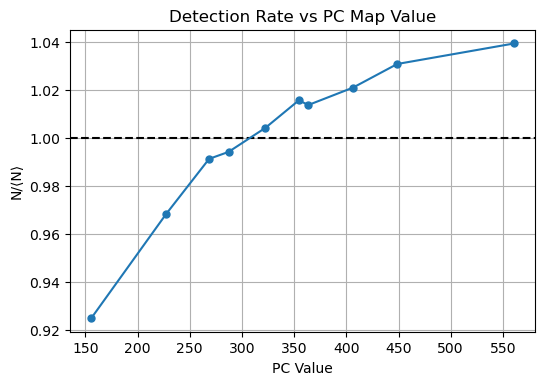

[3]


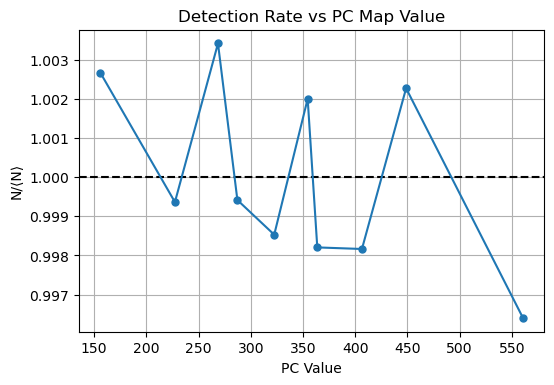

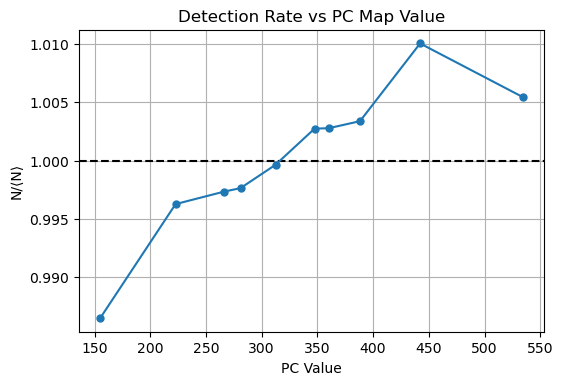

[2]


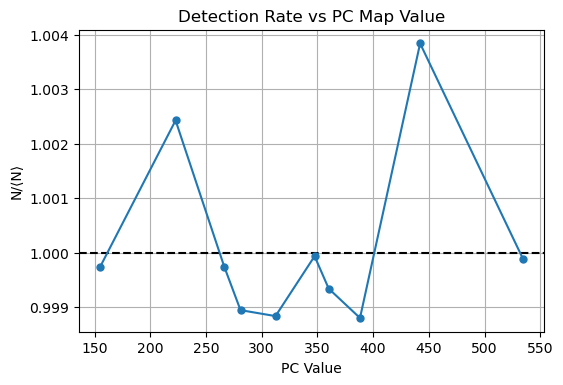

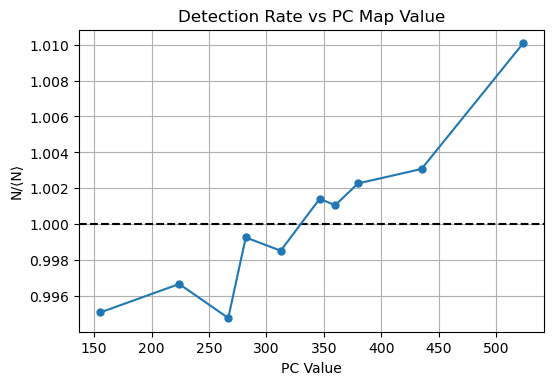

[3]


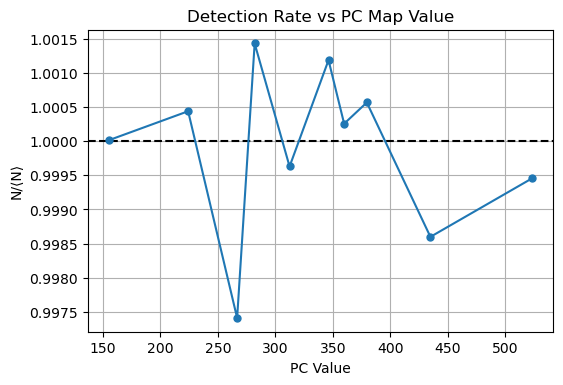

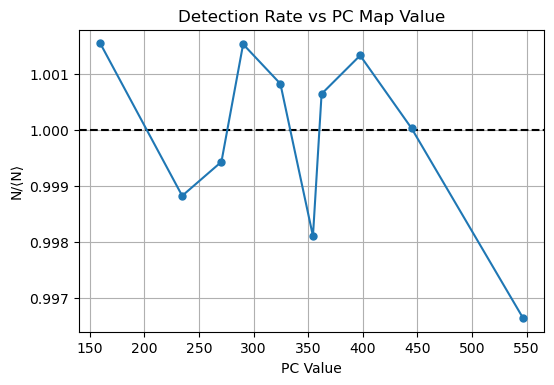

KeyboardInterrupt: 

In [24]:
trimRedMaps = np.copy(condMaps)

for index in np.arange(len(trimRedMaps)):
        
    plotNoFit(index, trimRedMaps, detStar)
    
    degree = findBestDegree(index, trimRedMaps, detStar)
    
    print(degree)

    fitParams = getFitParams(index, trimRedMaps, detStar, fitDegree = degree)

    correction = np.full(len(detStar), 0.0)

    for i in range(len(fitParams)):
        correction = correction + (fitParams[i] * (trimRedMaps[index]**(len(fitParams) - 1 - i)))

    correction = 1 / correction

    detStar = detStar * correction
    
    plotNoFit(index, trimRedMaps, detStar)

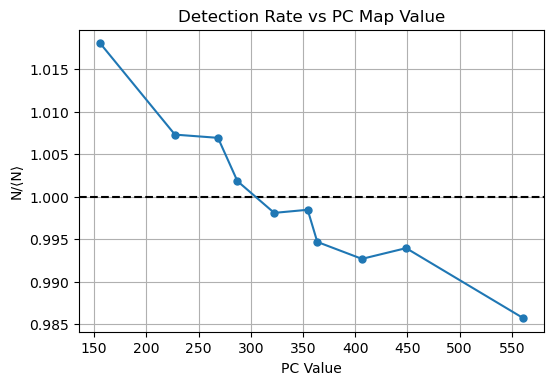

In [25]:
plotNoFit(36, trimRedMaps, detStar)

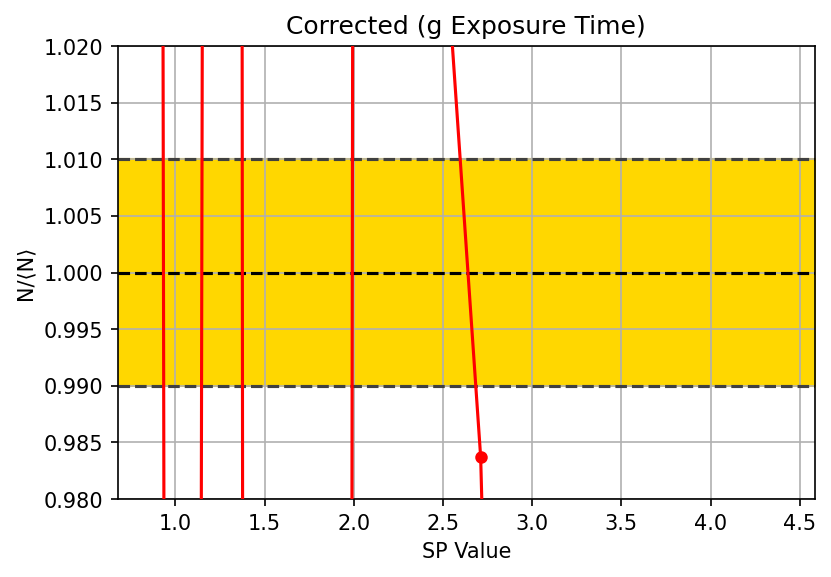

In [19]:
oneMap = condMaps[Config.stellarDens]

binIndLims = [0]

for i in range(numBins):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBins - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = detStar[sortInds[::1]]
injStarTemp = injStar[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBins):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBins):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
# plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'silver')
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
plt.ylim([0.98, 1.02])
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Corrected (g Exposure Time)')
plt.grid(zorder = 0)
plt.show()

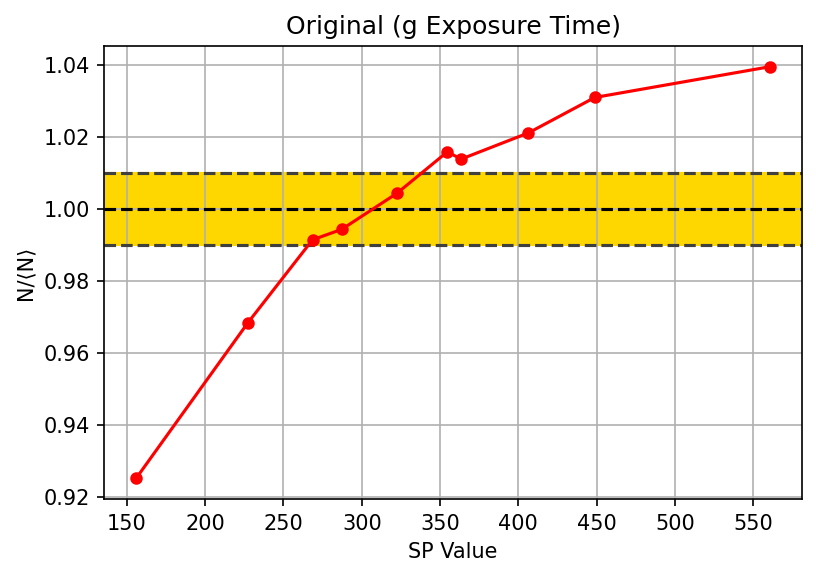

In [16]:
oneMap = condMaps[Config.exptimeSUMg]

binIndLims = [0]

for i in range(numBins):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBins - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = originalDetStar[sortInds[::1]]
injStarTemp = injStar[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBins):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBins):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
# plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'silver')
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Original (g Exposure Time)')
plt.grid(zorder = 0)
plt.show()